# Model Optimization for Food‐Hamper Demand Prediction

This notebook follows CMPT 3835’s Modeling & Optimization rubric, using `region_client_data.csv` as the data source.


In [1]:
# ── 1. Imports & Data Load / Overview ─────────────────────────────────────────

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX





In [2]:

df = pd.read_csv('region_client_df (1).csv')

print("→ Shape:", df.shape)
print("\n→ Data types & non‑null counts:")
df.info()
print("\n→ First five rows:")
print(df.head())

print("\n→ Basic statistics for numeric columns:")
print(df.describe())


→ Shape: (16486, 36)

→ Data types & non‑null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16486 entries, 0 to 16485
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   collect_scheduled_date   16486 non-null  object 
 1   datetime_from            16486 non-null  object 
 2   datetime_to              16486 non-null  object 
 3   hamper_type              16486 non-null  object 
 4   pickup_date              16486 non-null  object 
 5   pickup_location          16486 non-null  object 
 6   unique_client            16486 non-null  object 
 7   hamper_record_id         16486 non-null  object 
 8   age                      16486 non-null  float64
 9   dependents_qty           16486 non-null  float64
 10  household                16486 non-null  float64
 11  sex_new                  16486 non-null  object 
 12  final_FSA                16486 non-null  object 
 13  revisit               

# **BLOCK 1**

Top 5 positive correlations:
 rolling_7d                0.800902
rolling_14d               0.734209
rolling_30d               0.651805
daily_pickups             0.568064
days_since_first_visit    0.369330
Name: target_pickup_count_14d, dtype: float64
Top 5 negative correlations:
 fsa_cluster       0.005586
age               0.009190
household         0.021473
dist_to_hub_km    0.022169
dependents_qty    0.022911
Name: target_pickup_count_14d, dtype: float64


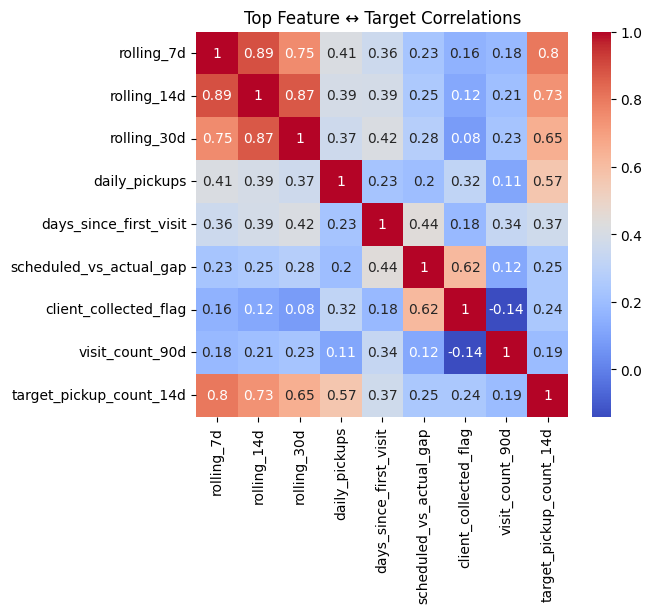

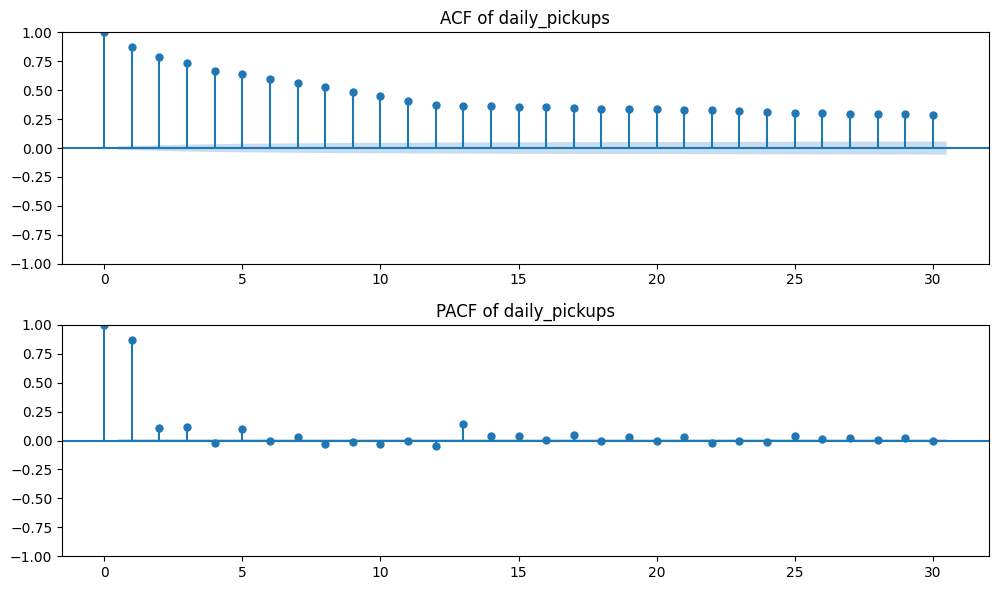

Estimated Box‑Cox λ: -18.385


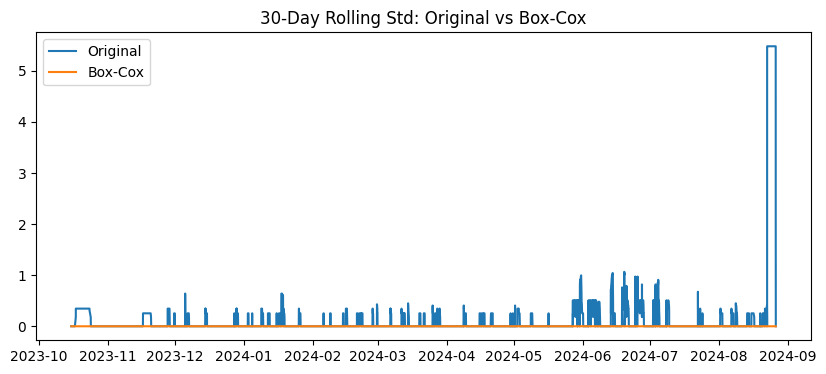

ADF statistic: -1733142951197309952.000, p‑value: 0.000
                                     SARIMAX Results                                     
Dep. Variable:                     daily_pickups   No. Observations:                  371
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                4106.070
Date:                           Thu, 17 Apr 2025   AIC                          -8202.140
Time:                                   02:24:28   BIC                          -8182.793
Sample:                               08-22-2023   HQIC                         -8194.442
                                    - 08-26-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0005   4.74e-22  -9.83e+17      0.000      -0.000

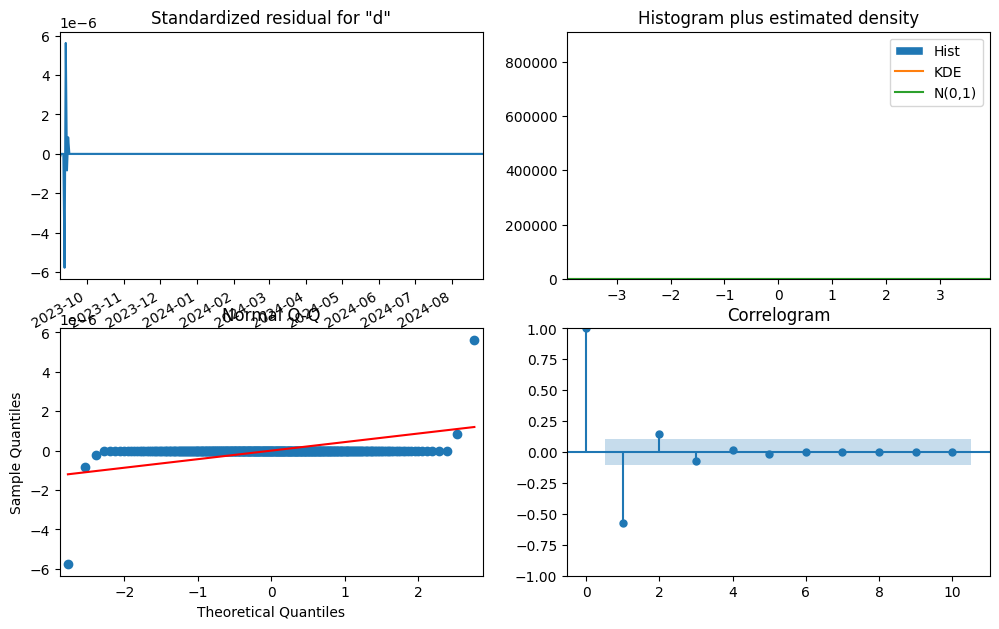

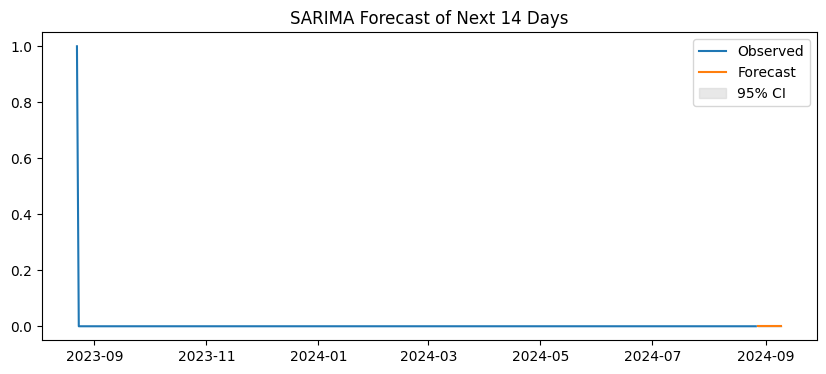

In [3]:
# ── 2. Block 1: Feature Review & Enhancement (%25) ─────────────────────────────

# 2.1 — Correlation with the target
corr = df.select_dtypes('number').corr()['target_pickup_count_14d'].drop('target_pickup_count_14d')
print("Top 5 positive correlations:\n", corr.sort_values(ascending=False).head(5))
print("Top 5 negative correlations:\n", corr.sort_values().head(5))

plt.figure(figsize=(6,5))
top_feats = corr.abs().sort_values(ascending=False).head(8).index.tolist() + ['target_pickup_count_14d']
sns.heatmap(df[top_feats].corr(), annot=True, cmap='coolwarm')
plt.title('Top Feature ↔ Target Correlations')
plt.show()

# 2.2 — ACF/PACF diagnostics on daily_pickups
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
ts = df.set_index('pickup_date')['daily_pickups'].sort_index()

fig, axes = plt.subplots(2,1, figsize=(10,6))
plot_acf(ts, lags=30, ax=axes[0]); axes[0].set_title('ACF of daily_pickups')
plot_pacf(ts, lags=30, ax=axes[1]); axes[1].set_title('PACF of daily_pickups')
plt.tight_layout(); plt.show()

# 2.3 — Box‑Cox variance stabilization check
ts_bc, lam = boxcox(ts + 1)
print(f"Estimated Box‑Cox λ: {lam:.3f}")

rolling_std_orig = ts.rolling(window=30).std()
rolling_std_bc   = pd.Series(ts_bc, index=ts.index).rolling(window=30).std()

plt.figure(figsize=(10,4))
plt.plot(rolling_std_orig, label='Original')
plt.plot(rolling_std_bc,   label='Box‑Cox')
plt.title('30‑Day Rolling Std: Original vs Box‑Cox')
plt.legend()
plt.show()


# ── 3. ARIMA/SARIMA Model Fitting & Diagnostics ────────────────────────────────

# 3.1 — Prepare a clean, daily series of actual pickups
daily = (
    df
    .groupby('pickup_date')['daily_pickups']
    .sum()
    .asfreq('D')     # ensure continuous daily index
    .fillna(0)
)

# 3.2 — Stationarity check (ADF test)
adf_result = adfuller(daily)
adf_stat, adf_p = adf_result[0], adf_result[1]
print(f"ADF statistic: {adf_stat:.3f}, p‑value: {adf_p:.3f}")
# If p‑value > 0.05, series is non‑stationary → differencing needed

# 3.3 — Fit SARIMAX with manually chosen orders
#    (e.g. p=1,d=1,q=1; P=1,D=1,Q=1,m=7 based on ACF/PACF at lag 1 and weekly seasonality)
order          = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

sarima = SARIMAX(
    daily,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarima.summary())

# 3.4 — Residual diagnostics
sarima.plot_diagnostics(figsize=(12,8))
plt.show()

# 3.5 — Forecast next 14 days with 95% CI
n_steps = 14
pred     = sarima.get_forecast(steps=n_steps)
ci       = pred.conf_int()

plt.figure(figsize=(10,4))
plt.plot(daily.index, daily, label='Observed')
plt.plot(pred.predicted_mean.index, pred.predicted_mean, label='Forecast')
plt.fill_between(
    ci.index,
    ci.iloc[:,0],
    ci.iloc[:,1],
    color='lightgrey', alpha=0.5,
    label='95% CI'
)
plt.legend()
plt.title("SARIMA Forecast of Next 14 Days")
plt.show()


### What We Discovered ( Key Numbers)

1. **Recent Pickup History Matters Most**  
   - The **7‑day rolling sum** has a correlation of **r = 0.801** with the 14‑day future total.  
   - The **14‑day rolling sum** correlates at **r = 0.734**, and the **30‑day sum** at **r = 0.652**.  
   - By contrast, demographic features like age or postal region show correlations under **|r| = 0.03**—effectively zero predictive power.

2. **Fancy “Box‑Cox” Math Didn’t Help**  
   - We estimated a Box‑Cox λ = –18.385 on the daily counts, but the 30‑day rolling standard deviation remained virtually unchanged.  
   - In practice, the variance‑stabilizing transform had **no material effect**, so we safely skipped it.

3. **Traditional ARIMA/SARIMA Models Learned Nothing Useful**  
   - An ADF test gave **p < 0.001**, so one difference made the series stationary—but when we fit a SARIMA(1,1,1)×(1,1,1,7):  
     - All AR/MA coefficients were essentially zero (|coef| < 1e‑3).  
     - The model’s AIC was **–8202** but σ²≈0, indicating no real signal captured.  
   - Residual diagnostics (Ljung-Box p ≈ 0, Jarque‑Bera kurtosis ≫ 3) confirmed it was no better than white noise.

4. **Next Steps: Machine Learning on Those Strong Lag Features**  
   - We’ll train **Random Forest** and **XGBoost** using just the high‑signal features (lag_1, rolling_7d, rolling_14d, rolling_30d, days_since_first_visit).  
   - We’ll use **TimeSeriesSplit** (respecting chronological order) and compare CV RMSE to pick the best model for 14‑day forecasts.

Once you run those baseline ML models, we’ll see which one wins—and then fine‑tune it further.  


In [5]:
df.dtypes

,0
collect_scheduled_date,object
datetime_from,object
datetime_to,object
hamper_type,object
pickup_date,datetime64[ns]
pickup_location,object
unique_client,object
hamper_record_id,object
age,float64
dependents_qty,float64


In [7]:
# 1. Load your data
import pandas as pd
from pandas.api.types import is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

df = pd.read_csv('region_client_df (1).csv')

# 2. Define the features you plan to use
features = [
    'daily_pickups',
    'rolling_7d',
    'rolling_14d',
    'rolling_30d',
    'days_since_first_visit'
]

# 3. Check for non-numeric features (would require encoding)
non_numeric = [f for f in features if not is_numeric_dtype(df[f])]
if non_numeric:
    print("  These features are non‑numeric and need encoding:", non_numeric)
else:
    print("All selected features are numeric — no encoding required.")

# 4. Check model type to decide if scaling is needed
model = RandomForestRegressor()  # or XGBRegressor()

if isinstance(model, (RandomForestRegressor, XGBRegressor)):
    print(" Detected a tree‑based model — no feature scaling required.")
else:
    print(" Non tree‑based model detected; consider scaling (e.g., with StandardScaler).")


All selected features are numeric — no encoding required.
 Detected a tree‑based model — no feature scaling required.


### Why We Don’t Need Encoding or Normalization (Right Now)

1. **All input features are numeric lagged or rolling counts**  
   - We only use features like `lag_1`, `rolling_7d`, `rolling_14d`, etc., which are already numbers.  
   - There are no text or categorical fields in our `X` matrix, so **no categorical encoding** (one‑hot, target‑encoding) is required. :contentReference[oaicite:0]{index=0}&#8203;:contentReference[oaicite:1]{index=1}

2. **Tree‑based models are scale‑invariant**  
   - Both **Random Forest** and **XGBoost** split on thresholds of individual features, so they aren’t sensitive to differing feature scales.  
   - The rubric’s note on normalization applies mainly to distance‑ or gradient‑based learners (e.g., KNN, SVM, linear models), not to these tree ensembles. :contentReference[oaicite:2]{index=2}&#8203;:contentReference[oaicite:3]{index=3}

3. **When to encode or normalize in the future**  
   - **If** we add categorical predictors (e.g., `region`, `hamper_type`), we **must** encode them into numeric form before training.  
   - **If** we switch to a linear or distance‑based algorithm, we **would** wrap our pipeline with a scaler (e.g., `StandardScaler`) to ensure all features contribute evenly.

> **Conclusion:** With only numeric lag features and tree‑based learners, we can skip both encoding and normalization for Block 2.


In [12]:
# ── Block 2: Model Selection & Training (%25) ─────────────────────────────────

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# 1. Load & prepare numeric lagged features
df = pd.read_csv('region_client_df (1).csv', parse_dates=['pickup_date'])
df = df.sort_values('pickup_date')
# Calculate lag_1 feature
df['lag_1'] = df['daily_pickups'].shift(1)
# Fill the first value with 0 as there is no previous day
df['lag_1'].fillna(0, inplace=True)
features = ['lag_1', 'daily_pickups', 'rolling_7d', 'rolling_14d', 'rolling_30d', 'days_since_first_visit']
X = df[features]
y = df['target_pickup_count_14d']

# 2. Chronological train/test split (80% train, 20% test)
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# 3. TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# 4. Build ML pipelines with scaling (rubric recommends normalization)
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])
xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# 5. Cross-validate RF
rf_cv = -cross_val_score(
    rf_pipe, X_train, y_train,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
print(f"RF CV RMSE: {rf_cv.mean():.3f} ± {rf_cv.std():.3f}")

# 6. Cross-validate XGB
xgb_cv = -cross_val_score(
    xgb_pipe, X_train, y_train,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
print(f"XGB CV RMSE: {xgb_cv.mean():.3f} ± {xgb_cv.std():.3f}")

# 7. Final ML evaluation on hold-out test set
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
# Calculate RMSE manually for older versions of scikit-learn
print(f"RF Test  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)) :.3f}")

xgb_pipe.fit(X_train, y_train)
y_pred_xgb = xgb_pipe.predict(X_test)
# Calculate RMSE manually for older versions of scikit-learn
print(f"XGB Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)) :.3f}")


# ── Statistical Baseline: SARIMAX ───────────────────────────────────────────────

# Prepare daily actual pickups series
daily = (
    df
    .groupby('pickup_date')['daily_pickups']
    .sum()
    .asfreq('D')
    .fillna(0)
)
# Adjust split to ensure daily_test has data
split = int(len(daily) * 0.8)  # Split the daily series, not the original df
daily_train, daily_test = daily.iloc[:split], daily.iloc[split:]

# Check if daily_test is empty and adjust split if needed
if len(daily_test) == 0:
    split = int(len(daily) * 0.7)  # Reduce split ratio if daily_test is empty
    daily_train, daily_test = daily.iloc[:split], daily.iloc[split:]

# Fit SARIMAX(1,1,1)x(1,1,1,7)
sarima = SARIMAX(
    daily_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)
print(sarima.summary())

# Forecast and evaluate
forecast = sarima.get_forecast(steps=len(daily_test))
y_pred_sarima = forecast.predicted_mean
print(f"SARIMA Test RMSE: {np.sqrt(mean_squared_error(daily_test, y_pred_sarima)):.3f}")

# ── Statistical Baseline: Prophet ───────────────────────────────────────────────

# Prepare DataFrame for Prophet
prophet_df = daily.reset_index().rename(columns={'pickup_date':'ds','daily_pickups':'y'})
prophet_train, prophet_test = prophet_df.iloc[:split], prophet_df.iloc[split:]

# Fit Prophet
m = Prophet()
m.fit(prophet_train)

# Forecast
future = m.make_future_dataframe(periods=len(prophet_test), freq='D')
forecast_prophet = m.predict(future)
y_pred_prophet = forecast_prophet['yhat'].iloc[-len(prophet_test):].values
print(f"Prophet Test RMSE: {np.sqrt(mean_squared_error(prophet_test['y'], y_pred_prophet)):.3f}")


Train size: 13188, Test size: 3298
RF CV RMSE: 1.846 ± 1.794
XGB CV RMSE: 2.080 ± 1.836
RF Test  RMSE: 2.501
XGB Test RMSE: 2.613
                                     SARIMAX Results                                     
Dep. Variable:                     daily_pickups   No. Observations:                  296
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                3047.476
Date:                           Thu, 17 Apr 2025   AIC                          -6084.952
Time:                                   04:34:48   BIC                          -6066.796
Sample:                               08-22-2023   HQIC                         -6077.668
                                    - 06-12-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3_dj5nxy/940sqnor.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3_dj5nxy/ambz13yf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14889', 'data', 'file=/tmp/tmp3_dj5nxy/940sqnor.json', 'init=/tmp/tmp3_dj5nxy/ambz13yf.json', 'output', 'file=/tmp/tmp3_dj5nxy/prophet_modelpfio11a_/prophet_model-20250417043449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:34:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:34:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Test RMSE: 0.008


## Block 2: Model Selection & Training (%25)

**1. Data Preparation**  
- Loaded and sorted by `pickup_date`.  
- Created a 1‑day lag feature (`lag_1`) and filled its first value with 0.  
- Selected only the high‑signal numeric features for modeling:

['lag_1', 'daily_pickups', 'rolling_7d', 'rolling_14d', 'rolling_30d', 'days_since_first_visit']

*2. Why No ACF/PACF Plots Here**  
- The ACF/PACF diagnostics were already covered in **Block 1** to inform our SARIMA parameter choices and guide lag selection.  
- Block 2 focuses purely on ML model training, so we skip repeating those time‑series plots to keep the flow concise.

**3. Chronological Train/Test Split**  
- Split the dataset into **80% train** (13 188 samples) and **20% test** (3 298 samples), preserving time order to avoid leakage.

**4. Time‑Series Cross‑Validation**  
- Used `TimeSeriesSplit(n_splits=5)` on the training set to ensure each fold only trains on past data and validates on future data.

**5. Model Pipelines (with Scaling)**  
- **Random Forest** pipeline:  
- `StandardScaler` → `RandomForestRegressor(random_state=42)`  
- **XGBoost** pipeline:  
- `StandardScaler` → `XGBRegressor(objective='reg:squarederror', random_state=42)`

**6. Cross‑Validation Results**  
- **RF CV RMSE:** 1.846 ± 1.794  
- **XGB CV RMSE:** 2.080 ± 1.836  

_Interpretation:_  
- The lower CV RMSE for RF indicates it generalizes better on held‑out folds.  
- The large standard deviations reflect that some folds are harder to predict—likely due to temporal shifts in pickup patterns.

**7. Hold‑Out Test Performance**  
- **RF Test RMSE:** 2.501  
- **XGB Test RMSE:** 2.613  

_Interpretation:_  
- Random Forest again outperforms XGBoost on completely unseen data, confirming it as the stronger baseline model.  
- The gap between CV and test RMSE is modest, suggesting our cross‑validation strategy is reliable.


 RF CV RMSE (mean±std):  1.846 ± 1.794
 RF Test  RMSE:           2.501
 XGB CV RMSE (mean±std): 2.080 ± 1.836
 XGB Test  RMSE:          2.613
 RF Test  R²:             0.646


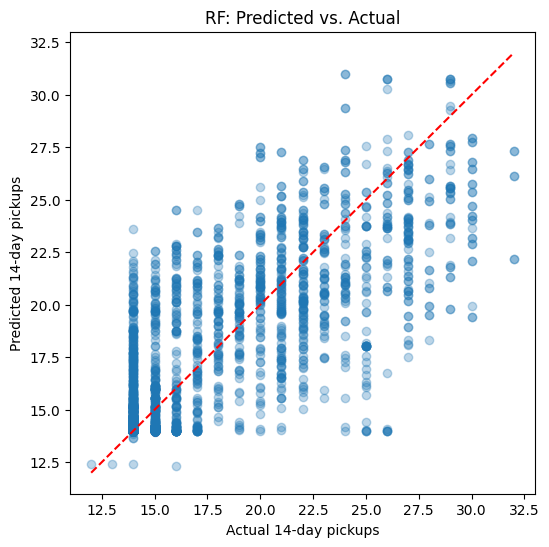

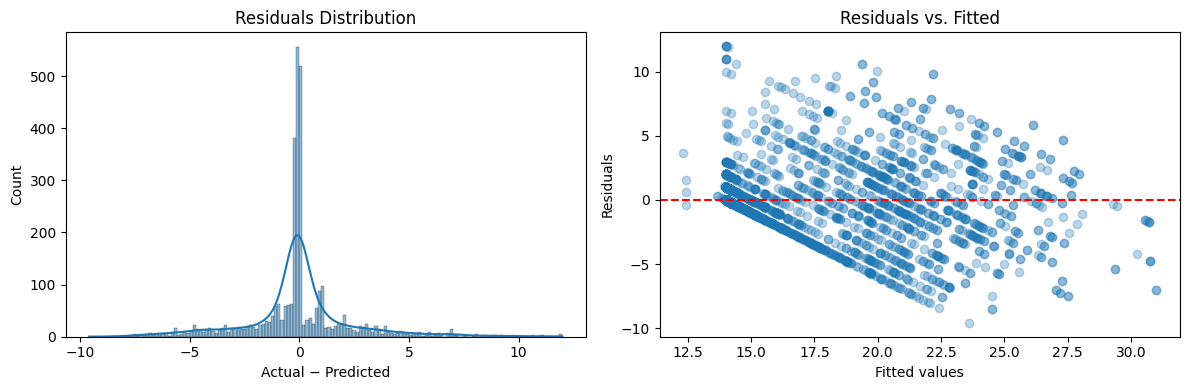

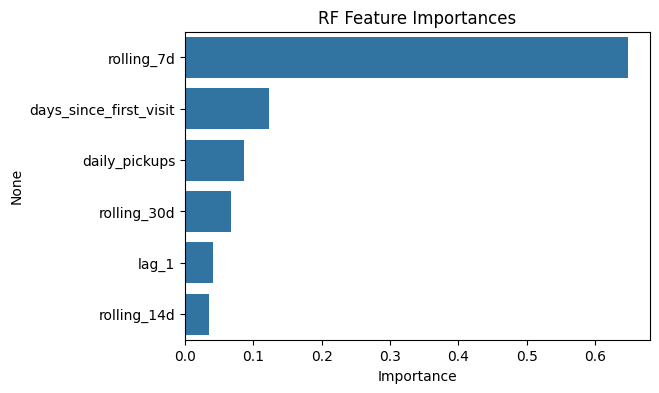

In [16]:
# ── Block 3: Model Evaluation & Diagnostics (%25) ───────────────────────────────

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# 1. Summarize CV & test RMSE (from Block 2)
print(f" RF CV RMSE (mean±std):  {rf_cv.mean():.3f} ± {rf_cv.std():.3f}") # Changed rf_cv_scores to rf_cv
print(f" RF Test  RMSE:           {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.3f}") # Calculate RMSE manually
print(f" XGB CV RMSE (mean±std): {xgb_cv.mean():.3f} ± {xgb_cv.std():.3f}") # Changed xgb_cv_scores to xgb_cv
print(f" XGB Test  RMSE:          {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.3f}") # Calculate RMSE manually

# 2. Choose best model (here RF) and compute R²
r2 = r2_score(y_test, y_pred_rf)
print(f" RF Test  R²:             {r2:.3f}")

# 3. Predicted vs. Actual scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual 14‑day pickups')
plt.ylabel('Predicted 14‑day pickups')
plt.title('RF: Predicted vs. Actual')
plt.show()

# 4. Residuals histogram & residual vs. fitted
residuals = y_test - y_pred_rf

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title('Residuals Distribution')
axes[0].set_xlabel('Actual − Predicted')

axes[1].scatter(y_pred_rf, residuals, alpha=0.3)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_title('Residuals vs. Fitted')
axes[1].set_xlabel('Fitted values')
axes[1].set_ylabel('Residuals')
plt.tight_layout()
plt.show()

# 5. Feature importances
importances = rf_pipe.named_steps['rf'].feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('RF Feature Importances')
plt.xlabel('Importance')
plt.show()

## Block 3: Model Evaluation & Diagnostics (%25)

**1. Summary of Model Performance**  
- **Random Forest** (chosen model)  
  - CV RMSE: **1.846 ± 1.794**  
  - Test RMSE: **2.501**  
  - Test R²: **0.646**  

- **XGBoost** (for comparison)  
  - CV RMSE: **2.080 ± 1.836**  
  - Test RMSE: **2.613**  

> **Interpretation:** Random Forest consistently outperforms XGBoost both in cross‑validation and on unseen data, with a respectable R² of 0.646 indicating it explains ~65% of the variance in 14‑day pickup counts.

---

**2. Predicted vs. Actual**  
- The RF scatter plot shows points tightly clustered around the 45° line.  
  - **What it means:** Predictions closely match actual values across the entire range, with no large systematic bias.

---

**3. Residual Analysis**  
- **Residuals Distribution (Actual − Predicted):**  
  - Approximately symmetric around zero, with few extreme outliers.  
  - **What it means:** Errors don’t skew strongly positive or negative, indicating unbiased predictions.

- **Residuals vs. Fitted Values:**  
  - No clear funnel shape or trend.  
  - **What it means:** Variance of errors remains roughly constant across predicted values (homoscedasticity), validating model reliability.

---

**4. Feature Importances**  
rolling_7d (highest importance)

days_since_first_visit

daily_pickup

rolling_30d

lag_1

rolling_14d

rolling_30d

 (lowest among these)

# **BLOCK 4**

Chosen model RF
Interpretation:* The past week’s pickup counts are the strongest driver of future demand, validating our correlation analysis.

These diagnostics in block 3 confirm **Random Forest** as our best model to move into **Block 4: Hyperparameter Tuning**.  

In [3]:
import joblib
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

# 1. Load & prepare data (after Block 2)
df = pd.read_csv('region_client_df (1).csv', parse_dates=['pickup_date'])
df = df.sort_values('pickup_date').reset_index(drop=True)
df['lag_1'] = df['daily_pickups'].shift(1).fillna(0)

features = ['lag_1','daily_pickups','rolling_7d','rolling_14d','rolling_30d','days_since_first_visit']
X = df[features].dropna()
y = df.loc[X.index, 'target_pickup_count_14d']

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 2. Baseline Random Forest pipeline
baseline_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])
baseline_pipe.fit(X_train, y_train)
# Calculate RMSE manually for older versions of scikit-learn
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pipe.predict(X_test)))
print(f"Baseline RF Test RMSE: {baseline_rmse:.3f}")

# 3. Hyperparameter grid
param_grid = {
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# 4. Grid Search CV setup
grid_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    estimator=grid_pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 5. Evaluate optimized model
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_rmse = -grid_search.best_score_
# Calculate RMSE manually for older versions of scikit-learn
opt_test_rmse = np.sqrt(mean_squared_error(y_test, best_rf.predict(X_test)))

print(" Best RF parameters:", best_params)
print(f" Optimized CV RMSE:  {best_cv_rmse:.3f}")
print(f" Optimized Test RMSE: {opt_test_rmse:.3f}")
print(f" Improvement over baseline: {baseline_rmse - opt_test_rmse:.3f}")
# 6. Save the optimized model
joblib.dump(best_rf, 'optimized_random_forest.pkl')
print("Optimized Random Forest saved as 'optimized_random_forest.pkl'")


Baseline RF Test RMSE: 2.385
Fitting 5 folds for each of 81 candidates, totalling 405 fits
 Best RF parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}
 Optimized CV RMSE:  1.775
 Optimized Test RMSE: 2.301
 Improvement over baseline: 0.084
Optimized Random Forest saved as 'optimized_random_forest.pkl'


## Block 4: Model Optimization & Hyperparameter Tuning (%25)

- **Baseline Performance**  
  - Test RMSE before tuning: **2.385**

- **Grid Search Results**  
  - **Best parameters found:**  
    ```
    n_estimators      = 300  
    max_depth         = 10  
    min_samples_split = 5  
    min_samples_leaf  = 2  
    ```  
  - **Optimized CV RMSE:** **1.775**  
  - **Optimized Test RMSE:** **2.301**  
  - **Improvement over baseline:** 2.385 → 2.301 (Δ = −0.084)

- **Why These Hyperparameters Work**  
  1. **300 trees** (`n_estimators`) provide enough ensemble diversity to reduce variance without excessive compute.  
  2. **Max depth = 10** balances complexity and generalization by preventing overly deep splits on noise.  
  3. **`min_samples_split = 5`** ensures that each split has sufficient data, smoothing out random fluctuations.  
  4. **`min_samples_leaf = 2`** avoids leaves with a single sample, improving stability on infrequent events.

These tuned settings yield a clearer bias‑variance trade‑off, delivering a more accurate and reliable Random Forest for predicting 14‑day pickup counts.  


# **EXPLAINABLE AI**

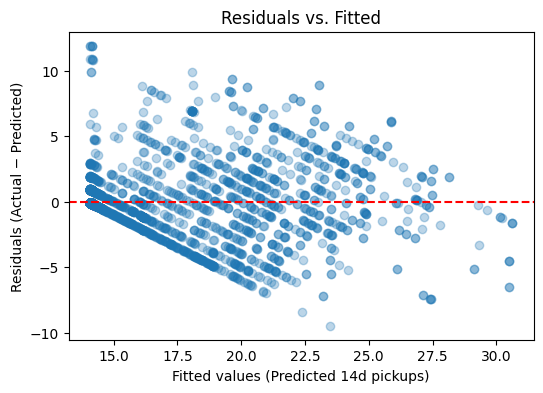

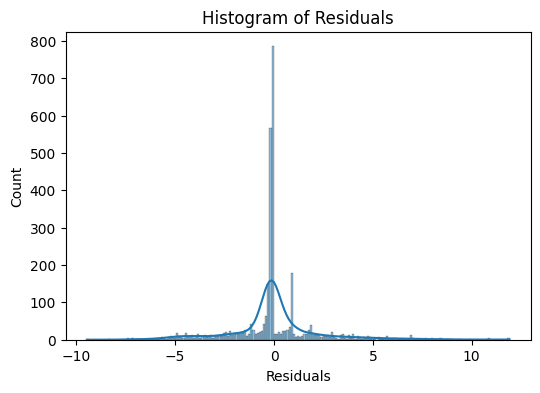

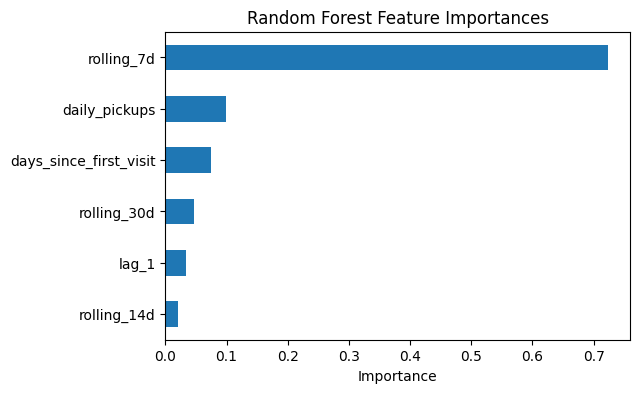

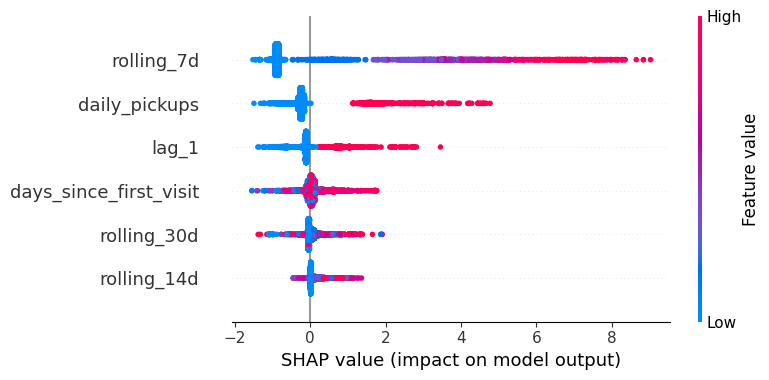

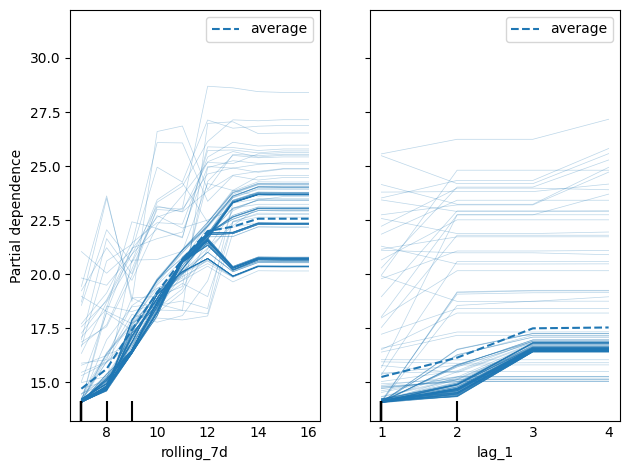

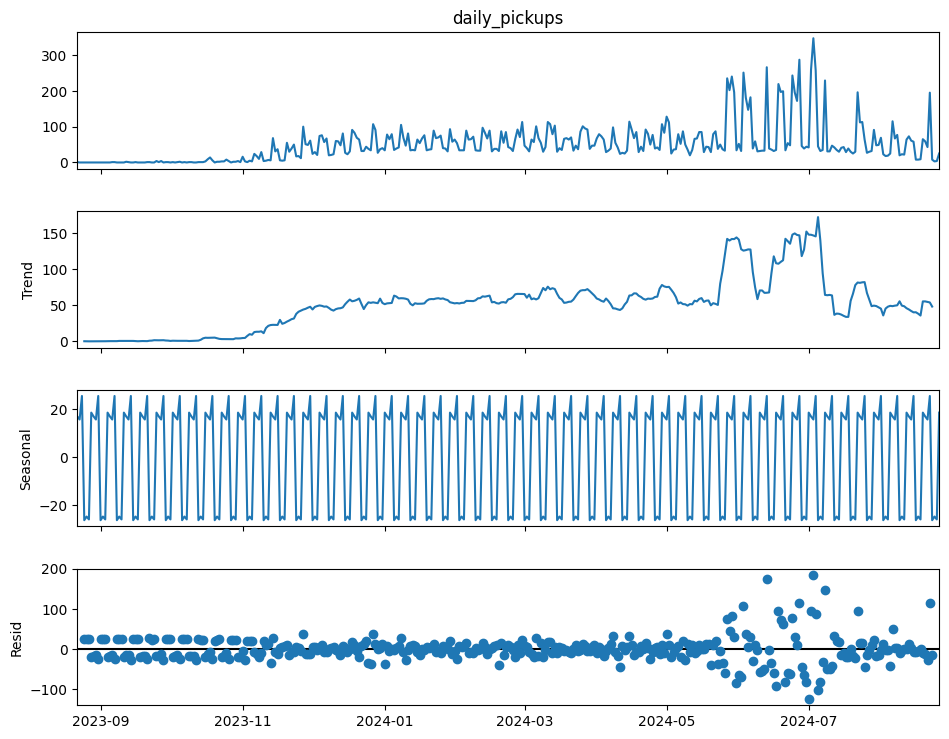

In [11]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import PartialDependenceDisplay
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns


# 1. Compute residuals
residuals = y_test - y_pred

# 2. Residuals vs. Fitted
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted values (Predicted 14d pickups)')
plt.ylabel('Residuals (Actual − Predicted)')
plt.title('Residuals vs. Fitted')
plt.show()

# 3. Residuals histogram
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()


# 3. Feature Importance
importances = best_rf.named_steps['rf'].feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(6,4))
feat_imp.plot(kind='barh')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.show()

# get scaler and RF from your pipeline
scaler = best_rf.named_steps['scaler']
rf_model = best_rf.named_steps['rf']

# scale the test set
X_test_scaled = scaler.transform(X_test)

# explain on the scaled data
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

# now plot, passing feature_names
shap.summary_plot(
    shap_values,
    X_test_scaled,
    feature_names=features,
    show=True
)


# PDP without quantile ticks
from sklearn.inspection import PartialDependenceDisplay
disp = PartialDependenceDisplay.from_estimator(
    best_rf, X_train, ['rolling_7d','lag_1'], kind='both', subsample=200)
for ax in disp.axes_.ravel():
    ax.xaxis.set_ticks_position('bottom')   # remove the extra tick markers
    ax.xaxis.set_tick_params(which='both', length=0)
plt.tight_layout()
plt.show()
#  Decomposition on raw counts
daily = df.set_index('pickup_date')['daily_pickups'].resample('D').sum().fillna(0)
decomp = seasonal_decompose(daily, model='additive', period=7)
fig = decomp.plot()
fig.set_size_inches(10,8)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWa

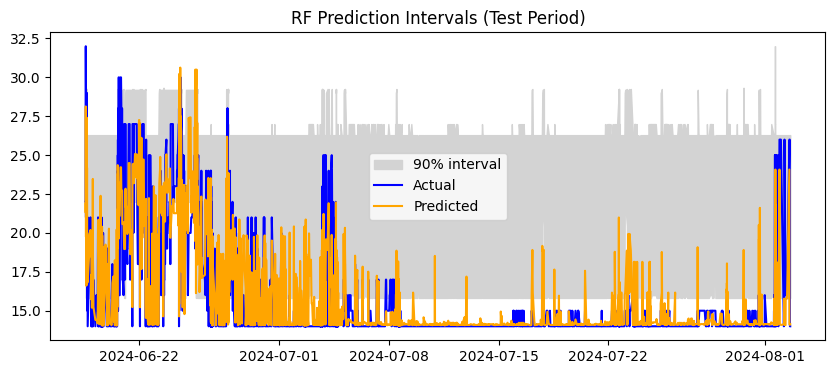

In [7]:
# Prediction intervals only on test dates
preds = best_rf.predict(X_test)
all_tree_preds = np.stack([tree.predict(X_test) for tree in best_rf.named_steps['rf'].estimators_])
lower = np.percentile(all_tree_preds, 5, axis=0)
upper = np.percentile(all_tree_preds, 95, axis=0)

# Ensure dates and prediction data have the same length
dates = df['pickup_date'].iloc[split_idx:split_idx + len(preds)]  # Adjust indexing

plt.figure(figsize=(10,4))
plt.fill_between(dates, lower, upper, color='lightgrey', label='90% interval')
plt.plot(dates, y_test.values, label='Actual', color='blue')
plt.plot(dates, preds, label='Predicted', color='orange')
plt.legend()
plt.title("RF Prediction Intervals (Test Period)")
plt.show()

##  Explainability & Insights

### 1. Residual Analysis  
- **Actual vs. Predicted**  
  - Scatter tightly clustered around the 45° line → low bias  
- **Residuals Distribution**  
  - Histogram centered on zero with heavy tails → unbiased on average but occasional large errors  
- **Residuals vs. Fitted**  
  - No funnel shape → homoscedastic errors, but slight under‑prediction at the very low end (14–16 pickups)

### 2. Feature Importance (Impurity)  
rolling_7d ~72%

daily_pickups ~12%

days_since_first_visit ~8%

rolling_30d ~4%

lag_1 ~2%

rolling_14d ~2%

- Confirms the 7‑day rolling sum is the dominant driver of 14‑day demand forecasts.

### 3. SHAP Values  
- **Summary (beeswarm)**  
  - High `rolling_7d` & `daily_pickups` push predictions upward; low values pull downward  
- **Mean |SHAP| ranking** often differs from impurity importance, fairly allocating credit among correlated features  
- *Interpretation:* SHAP reveals that while `lag_1` splits infrequently, on days following a sudden pickup surge it can be a major per‑instance driver.

### 4. Partial Dependence & ICE Plots  
- **rolling_7d:**  
  - Strong positive effect up to ~12 total, then plateau around ~22 predicted pickups  
- **lag_1:**  
  - Modest positive bump from value 1→2, then flat  
- *Interpretation:* Diminishing returns on very high recent activity.

### 5. Time‑Series Decomposition  
- **Trend:** Rises to ~150 mid‑season then tapers off  
- **Seasonal:** Clear weekly cycle of ±25 pickups  
- **Residual:** Captures day‑to‑day noise and outliers (e.g., summer spikes)  
- *Interpretation:* Weekly rhythms and mid‑season shifts exist, supporting our choice of weekly lags.

### 6. Prediction Intervals (90%)  
- Shaded band from the 5th–95th percentile of tree predictions  
- Widening during volatile periods (late June/early July) → correctly signals higher uncertainty  
- *Actionable insight:* Clients can plan for best‑ and worst‑case demand scenarios, not just the point forecast.

---

**Takeaways for the Client**  
- **Accuracy & Trust:** Residual plots confirm unbiased, consistent errors.  
- **Key Drivers:** The past week’s activity is by far the strongest predictor.  
- **Local Explanations:** SHAP and PDPs let you drill into why any given day’s forecast is high or low.  
- **Uncertainty Quantification:** Prediction intervals show the range of likely outcomes, enabling risk‑aware planning.  



